In [5]:
import SimpleITK as sitk
import numpy as np
import os
import pandas as pd
import scipy.ndimage
from skimage.segmentation import clear_border
import pylab

In [6]:
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

In [13]:
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution3D, Convolution2D, MaxPooling3D, MaxPooling2D
from keras import layers
from keras import Model
from keras.utils import np_utils
from keras import backend as K

### Fonctions

In [ ]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [ ]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

In [ ]:
from pre_processing import get_segmented_lungs

In [ ]:
def segment_lung_from_ct_scan(ct_scan,seuil):
    return np.asarray([get_segmented_lungs(slice,seuil) for slice in ct_scan])

In [ ]:
'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ca in cands.values:
        #get middel x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        
                        mask_x = int(max(0,min(image_mask.shape[0]-1,coords[0])))
                        mask_y = int(max(0,min(image_mask.shape[1]-1,coords[1])))
                        mask_z = int(max(0,min(image_mask.shape[2]-1,coords[2])))

                        image_mask[mask_x,mask_y,mask_z] = int(1)

    return image_mask

In [ ]:
'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npz
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, cands, imageName,path):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    # Segment the lung structure
    lung_img = lung_img + 1024
    lung_mask = segment_lung_from_ct_scan(lung_img,seuil=604)
    lung_img = lung_img - 1024

    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_img_512, lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((lung_mask.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape	
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = np.round(offset/2)
        lower_offset = offset - upper_offset

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

    # save images.    
    np.save(path + imageName + '_lung_img.npz', lung_img_512)
    np.save(path + imageName + '_lung_mask.npz', lung_mask_512)
    np.save(path + imageName + '_nodule_mask.npz', nodule_mask_512)
    
    #return
    return lung_img,lung_img_512

### Pre_processing

In [ ]:
INPUT_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/subset0'
patients_short = os.listdir(INPUT_FOLDER)

images = os.listdir(INPUT_FOLDER)
images_path = [os.path.join(INPUT_FOLDER,patient) for patient in patients_short]

In [ ]:
pos = 4

In [ ]:
first_image = load_itk(images_path[pos])

plt.imshow(first_image[0][pos],cmap=pylab.cm.bone)

In [ ]:
##annotations.csv contient l'id, x, y, z et le diametre des nodules malades
cands = pd.read_csv('/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/csv/annotations.csv')

##labels.csv contient l'id, x, y, z et si le nodules est malade ou non
labels = pd.read_csv('/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/csv/candidates.csv')

##Liste des cands pour chaque image
cands_list = []
for i in range(0,len(images)):
    cands_list.append(cands[cands['seriesuid'] == images[i][0:-4]])
    
##Liste des annotations pour chaque image
labels_list = []
for i in range(0,len(images)):
    labels_list.append(labels[labels['seriesuid'] == images[i][0:-4]])

In [ ]:
##On ne garde que les images en .mhd
images_mhd = [] 
for i in range(0,len(images)):
    if images[i][-4:] == '.mhd':
        images_mhd.append(images[i])
        
images_mhd_path = [os.path.join(INPUT_FOLDER,mhd) for mhd in images_mhd]
print(images_mhd[0])
print(images_mhd_path[0])

In [ ]:
first_img, origin, spacing = load_itk(images_path[pos])

In [ ]:
img_mask = draw_circles(first_img, cands_list[pos], origin, spacing)

In [ ]:
cands_list[pos].shape

In [ ]:
processed_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/processed/'
lung_img,lung_img_512 = create_nodule_mask(images_mhd_path[pos], cands_list[pos], images_mhd[pos][0:-4],processed_folder)

In [ ]:
plt.imshow(lung_img_512[300],cmap = pylab.cm.bone)

In [ ]:
processed = os.listdir(processed_folder)
processed_path = [os.path.join(processed_folder,p) for p in processed]

nodule_mask = np.load(processed_path[1])
#lung_img = np.load(processed_path[2])

nodule_pos = np.where(nodule_mask==1)

### UNET

In [20]:
class DataGenerator(object):
    'Generates data for Keras'
    def __init__(self, dim_x = 512, dim_y = 512, dim_z = 1, batch_size = 32, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def generate(self,list_IDs,INPUT_FOLDER):
        #'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)
            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                # Generate data
                X, Y = self.__data_generation(list_IDs_temp,INPUT_FOLDER)

                yield X, Y
                    
    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self,list_IDs_temp,INPUT_FOLDER):
        #'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        Y = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        # Generate data

        for i, ID in enumerate(list_IDs_temp):
            # Store volume
            X[i, :, :, 0] = np.load(INPUT_FOLDER + '/' + ID + '_lung_img.npz.npy')
            # Store class
            Y[i,:,:,0] = np.load(INPUT_FOLDER + '/' + ID + '_nodule_mask.npz.npy')
        return X, Y

### UNET-VERIFICATION

In [14]:
# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [15]:
def generate_list_ID(folder):
	np_list = os.listdir(folder)
	list_IDs = []
	for i,name in enumerate(np_list):
		if name[-16:-8] == "lung_img":
			list_IDs.append(name[0:-17])
	return list_IDs

In [16]:
import keras.losses
import keras.metrics
from keras.models import load_model

In [17]:
h5_folder = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/UNET/h5'
keras.losses.dice_coef_loss = dice_coef_loss
keras.metrics.dice_coef = dice_coef
model_path_init = os.path.join(h5_folder,'UNET-0')
model = load_model(model_path_init)

__Tester avec une image test et une image train__

In [22]:
params = {'dim_x': 512,
	          'dim_y': 512,
	          'dim_z': 1,
	          'batch_size': 1,
	          'shuffle': False}
SUBSET_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/TEST'
list_IDs_subset = generate_list_ID(SUBSET_FOLDER)
subset_generator = DataGenerator(**params).generate(list_IDs_subset,SUBSET_FOLDER)

In [29]:
numero = 325
lung_to_predict = np.empty((1,512,512,1))
lung_to_predict[0,:,:,0] = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_lung_img.npz.npy'))
predict_subset = model.predict(lung_to_predict)
mask_predict = predict_subset[0,:,:,0]

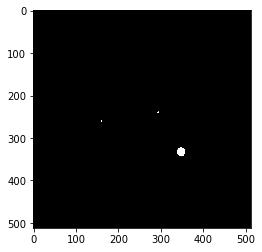

In [30]:
plt.imshow(mask_predict,cmap=pylab.cm.bone)

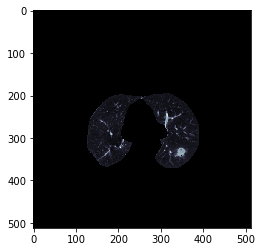

In [31]:
plt.imshow(lung_to_predict[0,:,:,0],cmap=pylab.cm.bone)

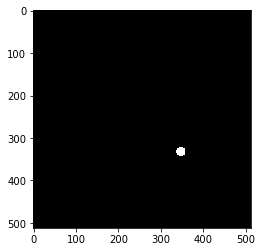

In [32]:
mask_real = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_nodule_mask.npz.npy'))
plt.imshow(mask_real,cmap=pylab.cm.bone)

In [27]:
#mask_real_full = np.empty((1,512,512,1))
#mask_real_full[0,:,:,0] = mask_real
#evaluate = model.evaluate(lung_to_predict,mask_real_full,batch_size=1)

1/1 [==============================] - 17s 17s/step


In [28]:
#evaluate[1]

0.55227059125900269

#### Evaluate avec seuil et de la bonne volontée

In [48]:
def seuil_mask_pred(mask_predict):
    for i in range(0, mask_predict.shape[0]):
        for j in range(0, mask_predict.shape[1]):
            if(mask_predict[i][j] < 0.1 or i > 500 or j >500):
                mask_predict[i][j] = 0
            else:
                mask_predict[i][j] = 1
    return(mask_predict)

In [49]:
def homemade_precision(y_true_f,y_pred_f):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(y_true_f)):
        if (y_pred_f[i] == 1 and y_true_f[i] ==1):
            TP += 1
        elif (y_pred_f[i] == 0 and y_true_f[i] ==1):
            FN += 1
        elif (y_pred_f[i] == 1 and y_true_f[i] ==0):
            FN += 0
    return(TP,FP,FN)

In [114]:
def calcul_precision(FOLDER):
    precision_list = []
    list_IDs_subset = generate_list_ID(FOLDER)
    for i,ID in enumerate(list_IDs_subset):
        mask_real = np.load(os.path.join(FOLDER,ID +'_nodule_mask.npz.npy'))
   
        lung_to_predict = np.empty((1,512,512,1))
        lung_to_predict[0,:,:,0] = np.load(os.path.join(FOLDER,ID+'_lung_img.npz.npy'))
        predict_subset = model.predict(lung_to_predict)
        mask_predict = predict_subset[0,:,:,0]
        
        mask_predict_seuil = seuil_mask_pred(mask_predict)
        
        y_true_f = mask_real.flatten()
        y_pred_f = mask_predict_seuil.flatten()
        TP,FP,FN = homemade_precision(y_true_f,y_pred_f)
        precision = float(TP)/float(FP+FN+TP)
        
        precision_list.append(precision)
        print(i)
        print(precision)
    return precision_list
        

In [115]:
calcul_precision(TEST_FOLDER)

0
0.866666666667
1
0.789473684211
2
0.0
3
0.0
4
0.0118764845606
5
0.0
6
0.512396694215
7
0.842975206612
8
0.0
9
0.933333333333
10
0.923076923077
11
0.0
12
1.0
13
0.583333333333
14
0.0
15
0.540540540541
16
0.0
17
1.0
18
0.0
19
0.521739130435
20
0.0
21
1.0
22
1.0
23
0.454545454545
24
0.0
25
0.0
26
1.0
27
0.0
28
0.375
29
0.0
30
0.764285714286
31
0.842323651452
32
0.0795454545455
33
0.0
34
0.0
35
0.0
36
0.747440273038
37
0.0
38
0.65625
39
0.975961538462
40
1.0
41
0.0
42
0.0
43
0.973333333333
44
0.0
45
0.0
46
0.0
47
1.0
48
0.0
49
0.0
50
0.0
51
0.75
52
0.0
53
0.0
54
0.602941176471
55
0.136363636364
56
0.0
57
0.0
58
0.914556962025
59
0.632978723404
60
0.75
61
0.0
62
0.0
63
1.0
64
0.96
65
0.666666666667
66
0.0
67
0.755555555556
68
0.524590163934
69
0.973404255319
70
0.7325
71
0.138686131387
72
0.0
73
1.0
74
0.855072463768
75
0.0
76
0.0
77
0.88
78
1.0
79
0.0
80
0.0
81
0.0113636363636
82
0.803571428571
83
0.0
84
0.911111111111
85
0.585365853659
86
0.796561604585
87
0.0
88
0.0
89
0.0
90
1.0
91
1.

KeyboardInterrupt: 

In [109]:
TEST_FOLDER = '/home/lucsoret/Projet/Supelec/CEI/Data/LUNA16/Images/TEST'
list_IDs_subset = generate_list_ID(TEST_FOLDER)
numero = 38
lung_to_predict = np.empty((1,512,512,1))
lung_to_predict[0,:,:,0] = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_lung_img.npz.npy'))
mask_real = np.load(os.path.join(SUBSET_FOLDER,list_IDs_subset[numero]+'_nodule_mask.npz.npy'))
predict_subset = model.predict(lung_to_predict)
mask_predict = predict_subset[0,:,:,0]

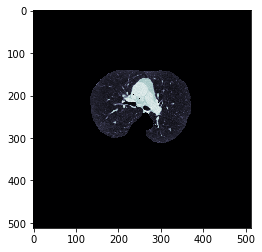

In [110]:
plt.imshow(lung_to_predict[0,:,:,0],cmap=pylab.cm.bone)

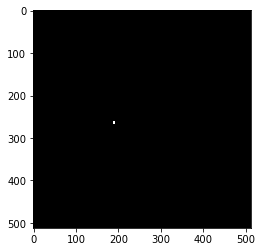

In [111]:
plt.imshow(mask_real,cmap=pylab.cm.bone)

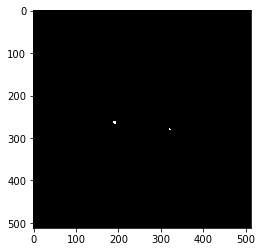

In [112]:
plt.imshow(mask_predict,cmap=pylab.cm.bone)

In [113]:
mask_predict = predict_subset[0,:,:,0]
mask_predict_seuil = seuil_mask_pred(mask_predict)
        
y_true_f = mask_real.flatten()
y_pred_f = mask_predict_seuil.flatten()
TP,FP,FN = homemade_precision(y_true_f,y_pred_f)
precision = float(TP)/float(FP+FN+TP)
        
print(precision)

0.65625


In [125]:
a = [1.0,0,0,2.0]
am

SyntaxError: invalid syntax (<ipython-input-125-a09d2e296a3a>, line 2)